In [251]:
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
from keras import backend as K


In [252]:
X_array = np.load('ip_sequences_new_10.npy')
Y_array = np.load('y_array_new_10.npy')

In [253]:
X_array.shape

(23929, 10, 7)

In [254]:
Y_array.shape

(23929, 1)

In [255]:
#let us see how many 1's we have.
y_ne= np.load('y_array_new_10.npy')

print(y_ne.shape)
ones=0
for item in y_ne:
    if item[0] == 1:
        ones += 1
print(ones)

(23929, 1)
1275


In [256]:
np.isnan(np.sum(X_array))

False

In [257]:
X_array.shape

(23929, 10, 7)

In [258]:
X_array=np.delete(X_array,[6], axis=2)
X_array=np.delete(X_array,[3], axis=2)

In [259]:
X_array.shape

(23929, 10, 5)

In [260]:
reduced_x_train, reduced_x_valid, reduced_y_train, reduced_y_valid = train_test_split(X_array, Y_array, test_size=0.1, shuffle= True,stratify=Y_array)

In [261]:
reduced_y_valid.shape

(2393, 1)

In [262]:
print(np.count_nonzero(Y_array == 1)/Y_array.shape[0], np.count_nonzero(Y_array == 0)/Y_array.shape[0])

print(np.count_nonzero(reduced_y_valid == 1)/reduced_y_valid.shape[0], np.count_nonzero(reduced_y_valid == 0)/reduced_y_valid.shape[0])




0.053282627773830915 0.946717372226169
0.05348934391976599 0.946510656080234


In [263]:
def min_max_normalization(new_X_array):
    new_x= np.zeros(new_X_array.shape)

    for i in range(new_X_array.shape[2]):
        
        min_val = new_X_array[0][0][i]
        max_val= new_X_array[0][0][i]
        for array in new_X_array:
            for item in array:
                if item[i] < min_val:
                    min_val = item[i]
                if item[i] > max_val:
                    max_val = item[i]

        for j, array in enumerate(new_X_array):
            for k, item in enumerate(array):
                new_x[j][k][i] = (item[i] - min_val) / (max_val - min_val)
                #x_test[j][k][i] = item[i]
    
    return new_x
    

In [264]:
new_x = min_max_normalization(reduced_x_valid)
new_x.shape

(2393, 10, 5)

In [265]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(new_x, reduced_y_valid, test_size=0.33, shuffle= True, stratify=reduced_y_valid)

In [266]:
print(np.count_nonzero(y_valid == 0))

748


In [267]:
model = keras.Sequential()
model.add(layers.LSTM(8,return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='relu'))
model.add(layers.LSTM(8, activation='relu'), )
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 10, 8)             448       
_________________________________________________________________
lstm_31 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [268]:
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [269]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', 'Precision', 'Recall', f1_m])

In [270]:
history = model.fit(x_train, y_train, batch_size=512,epochs=50, 
                    validation_data=(x_valid, y_valid))

Epoch 1/50
4/4 [==============================] - 2s 292ms/step - loss: 0.6869 - accuracy: 0.5180 - precision: 0.0864 - recall: 0.6800 - f1_m: 0.2530 - val_loss: 0.6459 - val_accuracy: 0.9570 - val_precision: 1.0000 - val_recall: 0.1905 - val_f1_m: 0.2986
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 0.6351 - accuracy: 0.9506 - precision: 1.0000 - recall: 0.1415 - f1_m: 0.2139 - val_loss: 0.5768 - val_accuracy: 0.9532 - val_precision: 1.0000 - val_recall: 0.1190 - val_f1_m: 0.1922
Epoch 3/50
4/4 [==============================] - 0s 13ms/step - loss: 0.5600 - accuracy: 0.9545 - precision: 1.0000 - recall: 0.1701 - f1_m: 0.2926 - val_loss: 0.4602 - val_accuracy: 0.9734 - val_precision: 1.0000 - val_recall: 0.5000 - val_f1_m: 0.6386
Epoch 4/50
4/4 [==============================] - 0s 13ms/step - loss: 0.4301 - accuracy: 0.9704 - precision: 0.9712 - recall: 0.4485 - f1_m: 0.5788 - val_loss: 0.2460 - val_accuracy: 0.9797 - val_precision: 0.9333 - val_recall: 0.666

In [272]:
model.predict(x_valid[0].reshape(1,x_valid[0].shape[0], x_valid[0].shape[1]))

array([[0.08502439]], dtype=float32)

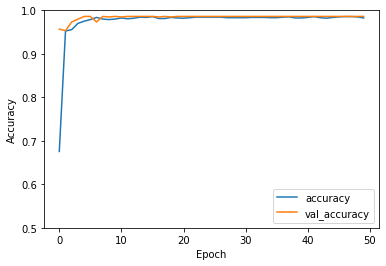

In [273]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(x_valid, y_valid, verbose=2)


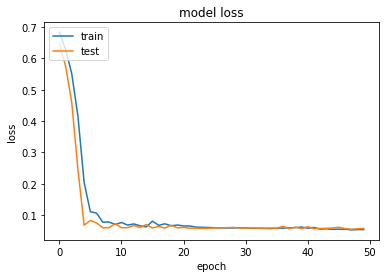

In [274]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

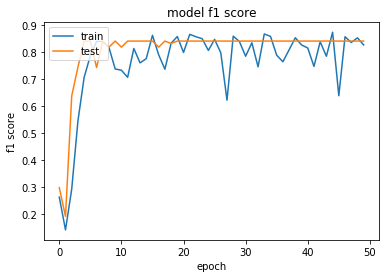

In [275]:
# summarize history for f1 score
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()